In [128]:
import random
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [10, 10]

In [93]:
file_dlls = []
func_dlls = []
file_funcs = []
files = []
funcs = []
dlls = []
with open('../edge_lists/bin_dll_func.csv') as file:
    for line in file:
        line_split = line.split(",")
        if len(line_split) == 4 and line_split[3] == ' "NAME"\n':
            line_split = [x.strip() for x in line_split]
            line_split = [x.strip('"') for x in line_split]
            file, dll, func = line_split[0:3]
            func = "{}_{}".format(dll, func)
            
            if len(files) < 10:
                file_dlls.append((file, dll))
                func_dlls.append((func, dll))
                file_funcs.append((file, func))
                
                if file not in files:
                    files.append(file)
                    
                if dll not in dlls:
                    dlls.append(dll)
                    
                if func not in funcs:
                    funcs.append(func)

In [94]:
file_dlls = list(set(file_dlls))
func_dlls = list(set(func_dlls))
file_funcs = list(set(file_funcs))

In [99]:
arthrograph = nx.Graph()

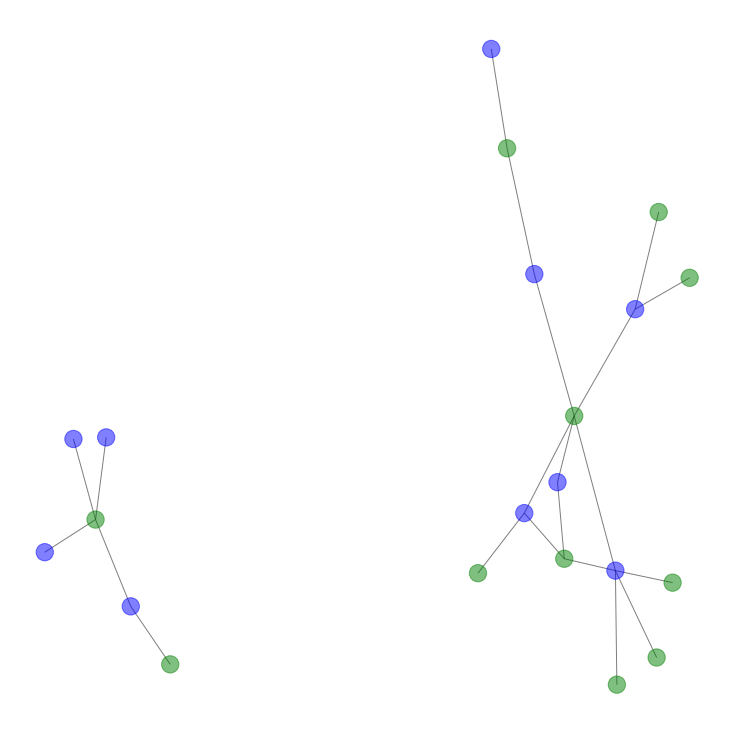

In [100]:
arthrograph.add_edges_from(file_dlls)

color_map = []
for node in arthrograph:
    if node in files:
        color_map.append('blue')
    else: 
        color_map.append('green')  

nx.draw(arthrograph, node_color = color_map,with_labels = False, alpha = 0.5)

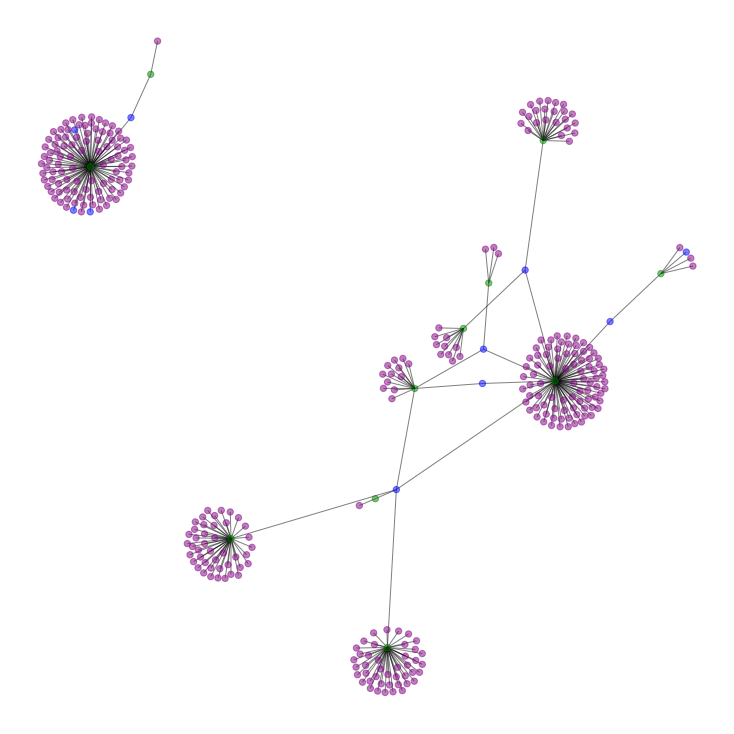

In [101]:
arthrograph.add_edges_from(func_dlls)

color_map = []
for node in arthrograph:
    if node in files:
        color_map.append('blue')
    elif node in dlls: 
        color_map.append('green')
    else:
        color_map.append('purple')

nx.draw(arthrograph, node_color = color_map, with_labels = False, node_size=40, alpha = 0.5)

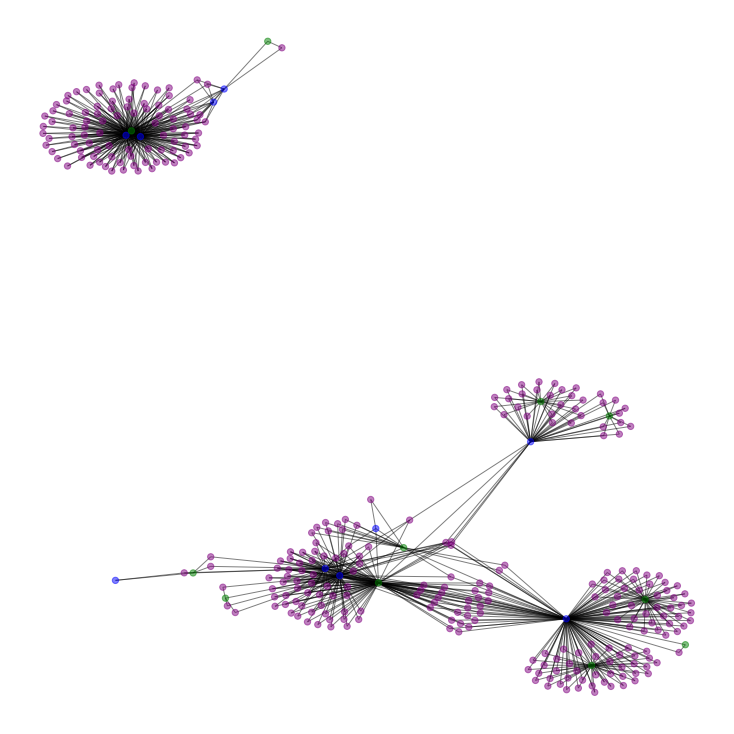

In [102]:
arthrograph.add_edges_from(file_funcs)

color_map = []
for node in arthrograph:
    if node in files:
        color_map.append('blue')
    elif node in dlls: 
        color_map.append('green')
    else:
        color_map.append('purple')

nx.draw(arthrograph, node_color = color_map, with_labels = False, node_size=40, alpha = 0.5)

Deepwalk Implementation

In [125]:
walks_per_node = 10
walk_length = 80
walks = []
for node in arthrograph:
    node_walks = 0
    while node_walks < walks_per_node:
        walk = [node]
        cur_node = node
        while len(walk) < walk_length:
            next_node = random.choice(list(arthrograph.neighbors(cur_node)))
            walk.append(next_node)
            cur_node = next_node
        walks.append(walk)
        node_walks += 1
# walks = np.array(walks)
# print(walks.shape)

In [126]:
model = Word2Vec(walks, size=32, window=5, min_count=1)

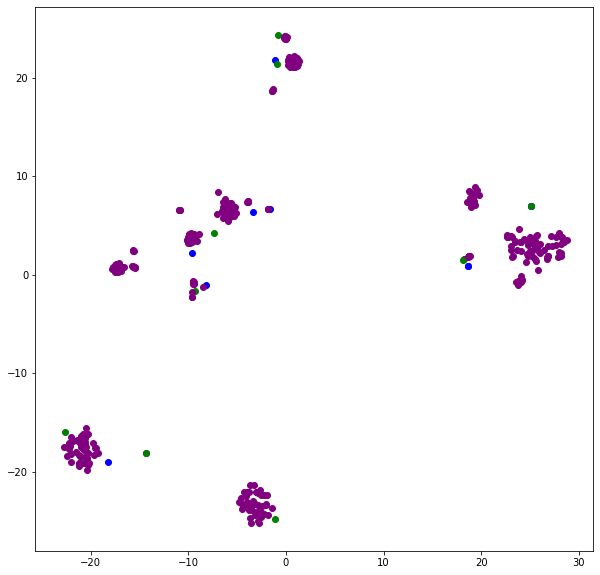

In [134]:
vocab = list(model.wv.vocab)
X = model[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for word, pos in df.iterrows():
    if word in files:
        pt_color = 'blue'
    elif word in dlls: 
        pt_color = 'green'
    else:
        pt_color = 'purple'
        
    ax.scatter(pos[0], pos[1], color=pt_color)

GraphSage Implementation